# GENERATIVE ADVERSARIAL NETWORK (GAN)

## Imports 

***mount drive***

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


***general imports***

In [2]:
import numpy as np 
import os 
import pandas as pd
import matplotlib.pyplot as plt 
from zipfile import ZipFile

%matplotlib inline

***keras imports***

In [3]:
import keras 
from keras.models import Sequential, Model
from keras.layers import  Input, Dense, Conv2D, BatchNormalization, Dropout, \
                          Flatten, Activation, Reshape, Conv2DTranspose, \
                          UpSampling2D 
from keras.optimizers import RMSprop

***unziping a file***

In [4]:
zipfile_path = "/content/drive/MyDrive/Youtube/8 - GAN/apple.zip"
unzipfile_path = "/content/drive/MyDrive/Youtube/8 - GAN/dataset/"
zipfile = ZipFile(zipfile_path)

with zipfile as zipObj:
  zipObj.extractall(unzipfile_path)

## Load Data

***load data by setting path***

In [5]:
images_path = "/content/drive/MyDrive/Youtube/8 - GAN/dataset/apple.npy"

dataset = np.load(images_path)

dataset.shape

(144722, 784)

## Pre-Process Data

***scale features***

In [6]:
dataset = dataset/255.0

***reshape***

In [7]:
dataset = np.reshape(dataset, (-1, 28, 28, 1))

IMG_WIDTH, IMG_HEIGHT = dataset.shape[1:3]

dataset.shape

(144722, 28, 28, 1)

***checking image example***

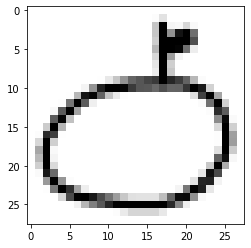

In [8]:
plt.imshow(dataset[2654, :, :, 0], cmap="Greys")

## Build Model Architecture

***function - build the discriminator model structure***

In [9]:
def discriminator_builder(depth=64, p=0.4):

  inputs = Input((IMG_WIDTH, IMG_HEIGHT, 1))

  conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
  conv1 = Dropout(p)(conv1)
  
  conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
  conv2 = Dropout(p)(conv2)
  
  conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
  conv3 = Dropout(p)(conv3)
  
  conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))
  
  
  output = Dense(1, activation='sigmoid')(conv4)
  
  
  model = Model(inputs=inputs, outputs=output)

  model.summary()

  model.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])
  
  return model

***function - build generator model structure*** 

In [10]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
  inputs = Input((z_dim,))
  
  dense1 = Dense(7*7*64)(inputs)
  dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
  dense1 = Activation(activation='relu')(dense1)
  dense1 = Reshape((7,7,64))(dense1)
  dense1 = Dropout(p)(dense1)
  
  conv1 = UpSampling2D()(dense1)
  conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
  conv1 = BatchNormalization(momentum=0.9)(conv1)
  conv1 = Activation(activation='relu')(conv1)

  conv2 = UpSampling2D()(conv1)
  conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
  conv2 = BatchNormalization(momentum=0.9)(conv2)
  conv2 = Activation(activation='relu')(conv2)
  
  conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
  conv3 = BatchNormalization(momentum=0.9)(conv3)
  conv3 = Activation(activation='relu')(conv3)
  
  output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
      
  model = Model(inputs=inputs, outputs=output)

  model.summary()
  
  return model

***function - build arversarial model structure***

In [11]:
def adversarial_builder(z_dim=100):

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  model.compile(loss='binary_crossentropy', 
                optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                metrics=['accuracy'])
  
  model.summary()
  return model

***build the discriminator structure***

In [12]:
discriminator = discriminator_builder()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


***build the generator structure***

In [13]:
generator = generator_builder()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

***build the adversarial model structure***

In [14]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 28, 28, 1)         396961    
                                                                 
 model (Functional)          (None, 1)                 4311553   
                                                                 
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


## Train the model

***function - control which layers are trainable***

In [15]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

***function - train the GAN model***

In [16]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(dataset[np.random.choice(dataset.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

***train the model***

0
4/4 [==============================] - 0s 4ms/step
100
4/4 [==============================] - 0s 4ms/step
200
4/4 [==============================] - 0s 3ms/step
300
4/4 [==============================] - 0s 4ms/step
400
4/4 [==============================] - 0s 4ms/step
Epoch #500
499: [D loss: 0.432663, acc: 0.883227]  [A loss: 2.890128, acc: 0.153197]
1/1 [==============================] - 0s 215ms/step


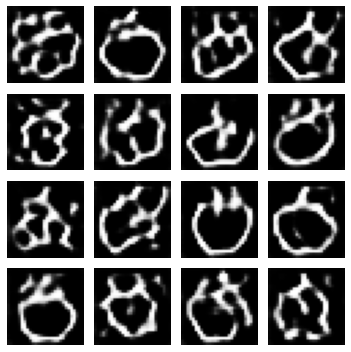

500
4/4 [==============================] - 0s 4ms/step
600
4/4 [==============================] - 0s 5ms/step
700
4/4 [==============================] - 0s 8ms/step
800
4/4 [==============================] - 0s 4ms/step
900
4/4 [==============================] - 0s 4ms/step
Epoch #1000
999: [D loss: 0.515424, acc: 0.785008]  [A loss: 2.103282, acc: 0.135221]
1/1 [==============================] - 0s 26ms/step


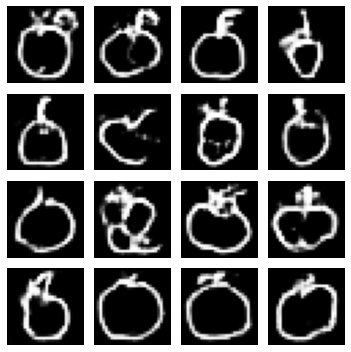

In [17]:
a_metrics_complete, d_metrics_complete = train(epochs=1000)

## Evaluate Model Performance

***plot loss over epochs***

Text(0, 0.5, 'Loss')

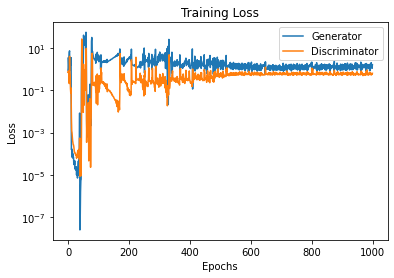

In [18]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

***plot accuracy over epochs***

Text(0, 0.5, 'Accuracy')

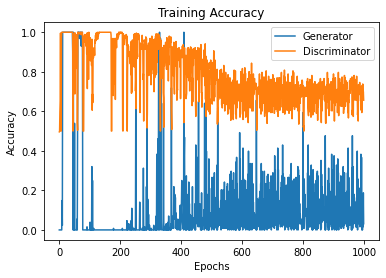

In [19]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")